In [ ]:
!pip install tensorflowjs

In [ ]:
text_labels = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

In [ ]:
import tensorflow as tf
import numpy as np
import random
import scipy.io
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
## UNCOMMENT ONLY IF UNZIPPING DATASET ###

import zipfile

with zipfile.ZipFile("jpg.zip", "r") as zip_ref:
    zip_ref.extractall("images")


folder_path = "images/jpg"

# Count all files (excluding subdirectories)
file_count = sum(1 for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file)))

print(f"Number of files: {file_count}")


Number of files: 8189


### Augmentation

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import scipy.io

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# OxfordFlowersDataset
# -----------------------------------------------------------------------------
class OxfordFlowersDataset:
    def __init__(self, image_folder, label_file):
        self.image_folder = image_folder
        self.label_file = label_file
        self.image_files = sorted([
            f for f in os.listdir(image_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.labels = self._load_labels()

    def _load_labels(self):
        label_data = scipy.io.loadmat(self.label_file)
        image_labels = label_data['labels'].flatten() - 1
        return to_categorical(image_labels, num_classes=102)

# -----------------------------------------------------------------------------
# Augmentation function
# -----------------------------------------------------------------------------

def gaussian_kernel(kernel_size=3, sigma=1.0):
    """Generate a 2D Gaussian kernel to use in convolution."""
    # Create a 1D range [-k, k]
    x = tf.range(-kernel_size//2 + 1, kernel_size//2 + 1, dtype=tf.float32)

    # Create 2D grid of (x,y) coordinates
    xx, yy = tf.meshgrid(x, x)

    # Compute Gaussian: exp(-(x^2 + y^2)/(2*sigma^2))
    kernel_2d = tf.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))

    # Normalize so that the sum of the kernel is 1
    kernel_2d /= tf.reduce_sum(kernel_2d)
    return kernel_2d

def apply_gaussian_blur(image, kernel_size=3, sigma=1.0):
    """Applies a Gaussian blur to a single image tensor (H,W,3)."""
    # Create a 2D Gaussian Kernel
    kernel_2d = gaussian_kernel(kernel_size, sigma)

    # Expand it to a 4D depthwise kernel: (kH, kW, in_channels, out_channels)
    # We'll replicate the same kernel for each of the 3 input channels.
    kernel_2d = kernel_2d[:, :, tf.newaxis, tf.newaxis]  # shape => (kH, kW, 1, 1)
    kernel_2d = tf.tile(kernel_2d, [1, 1, 3, 1])          # shape => (kH, kW, 3, 1)

    # Add batch dimension => (1, H, W, 3)
    image_4d = tf.expand_dims(image, axis=0)

    # Convolve using 'SAME' padding to maintain image size
    # Stride of 1 in both dimensions
    blurred_4d = tf.nn.depthwise_conv2d(
        image_4d,
        filter=kernel_2d,
        strides=[1, 1, 1, 1],
        padding='SAME'
    )

    # Remove batch dimension => (H, W, 3)
    blurred = tf.squeeze(blurred_4d, axis=0)
    return blurred

def random_blur(image, p=0.5, kernel_size=3, sigma=1.0):
    """Apply Gaussian blur to 'image' with probability p."""
    # Generate a random number
    should_blur = tf.random.uniform(()) < p

    # Use tf.cond to blur or skip
    image = tf.cond(
        should_blur,
        lambda: apply_gaussian_blur(image, kernel_size, sigma),
        lambda: image
    )
    return image



def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.rot90(
        image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
    image = random_blur(image, p=0.5, kernel_size=3, sigma=1.5)
    return image

# -----------------------------------------------------------------------------
# Replicate each image into (1 + num_augs) copies
#    => but store them in *parallel arrays* (paths, flags, labels)
# -----------------------------------------------------------------------------
def replicate_for_training(image_paths, labels, num_augmentations=3):
    """
    For each original (path, label), produce:
      - One entry with flag=0  (the "original")
      - num_augmentations entries with flag=1 (the "augmented" copies)
    Returns 3 lists of length N*(1+num_augmentations):
      final_paths: list of str
      final_flags: list of int (0/1)
      final_labels: list of 1D one-hot (length=102)
    """
    final_paths = []
    final_flags = []
    final_labels = []

    for path, lab in zip(image_paths, labels):
        # 1) Original
        final_paths.append(path)
        final_flags.append(0)
        final_labels.append(lab)

        # 2) Augmented copies
        for _ in range(num_augmentations):
            final_paths.append(path)
            final_flags.append(1)
            final_labels.append(lab)

    return final_paths, final_flags, final_labels

# -----------------------------------------------------------------------------
# The map function that actually loads + conditionally augments
# -----------------------------------------------------------------------------
def load_image_conditional(path, flag, label):
    """
    path:  tf.string
    flag:  tf.int32 (0 => original, 1 => augmented)
    label: one-hot vector (shape=[102])
    """
    # Load & preprocess
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255

    # MobileNetV2 => [-1,1]
    # image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    # If flag==1 => apply data augmentation
    image = tf.cond(
        tf.equal(flag, 1),
        lambda: augment_image(image),
        lambda: image
    )
    return image, label

# -----------------------------------------------------------------------------
# Build the train or val dataset
# -----------------------------------------------------------------------------
def build_dataset(image_paths, labels, batch_size=32, shuffle=True, training=True, num_augmentations=3):
    if training:
        # Expand each image into (1 + num_augmentations) copies
        final_paths, final_flags, final_labels = replicate_for_training(
            image_paths, labels, num_augmentations
        )
    else:
        # Validation => no augmentation => all flags = 0
        final_paths = list(image_paths)
        final_flags = [0]*len(image_paths)
        final_labels = list(labels)

    # Create a dataset of (path, flag, label) => string, int, float
    dataset = tf.data.Dataset.from_tensor_slices((final_paths, final_flags, final_labels))

    # Map to (image, label)
    dataset = dataset.map(load_image_conditional, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(final_paths))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



# 1) Load Oxford Flowers
dataset = OxfordFlowersDataset("images/jpg", "imagelabels.mat")
image_paths = [os.path.join("images/jpg", f) for f in dataset.image_files]
labels = dataset.labels

# 2) Shuffle in Python
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)

# 3) Train/val split
label_indices = np.argmax(labels, axis=1)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    stratify=label_indices,
    random_state=42
)

# 4) Build the train_dataset (with augmented copies) and val_dataset
train_dataset = build_dataset(
    train_paths,
    train_labels,
    batch_size=64,
    shuffle=True,
    training=True,        # => replicate + augment
    num_augmentations=3   # => 1 original + 3 augmented
)

val_dataset = build_dataset(
    val_paths,
    val_labels,
    batch_size=64,
    shuffle=False,
    training=False
)



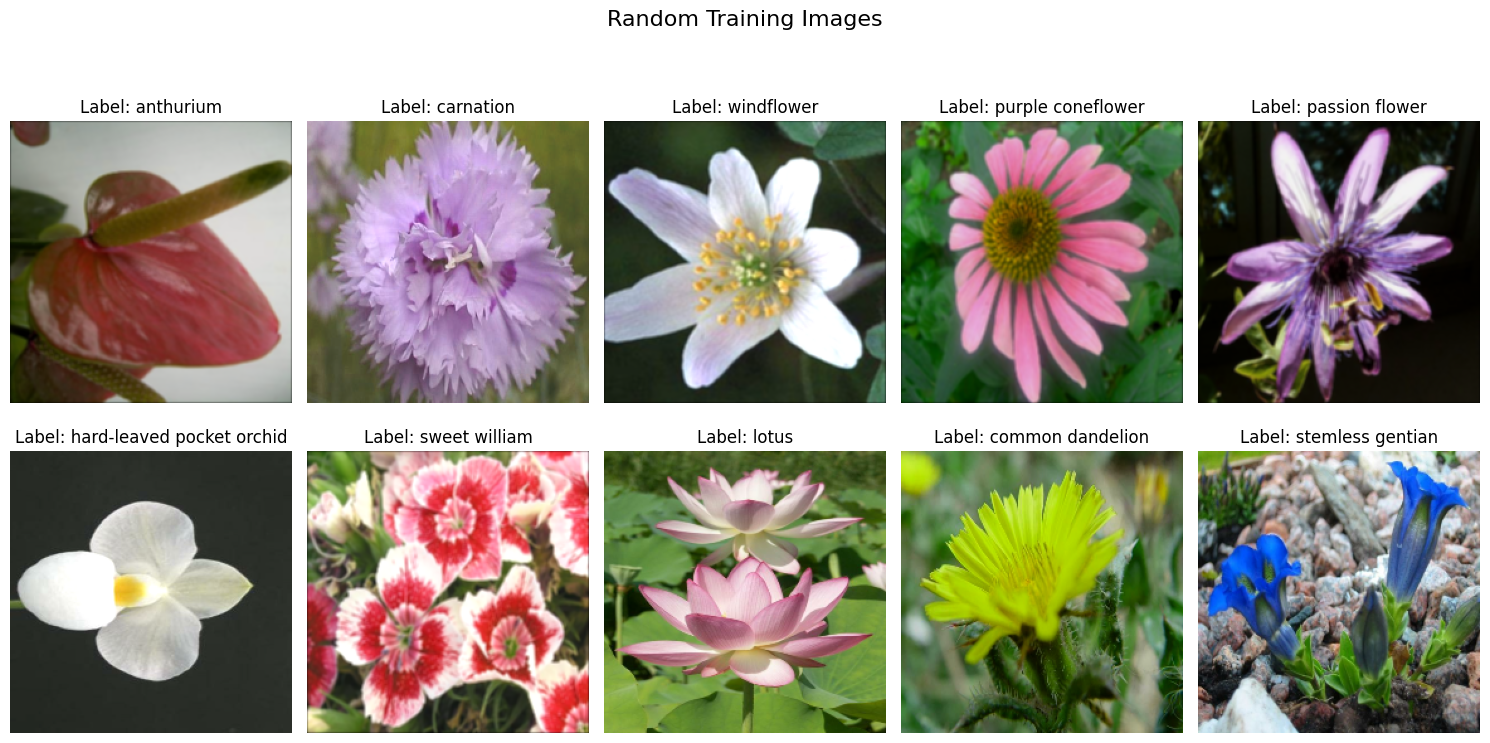

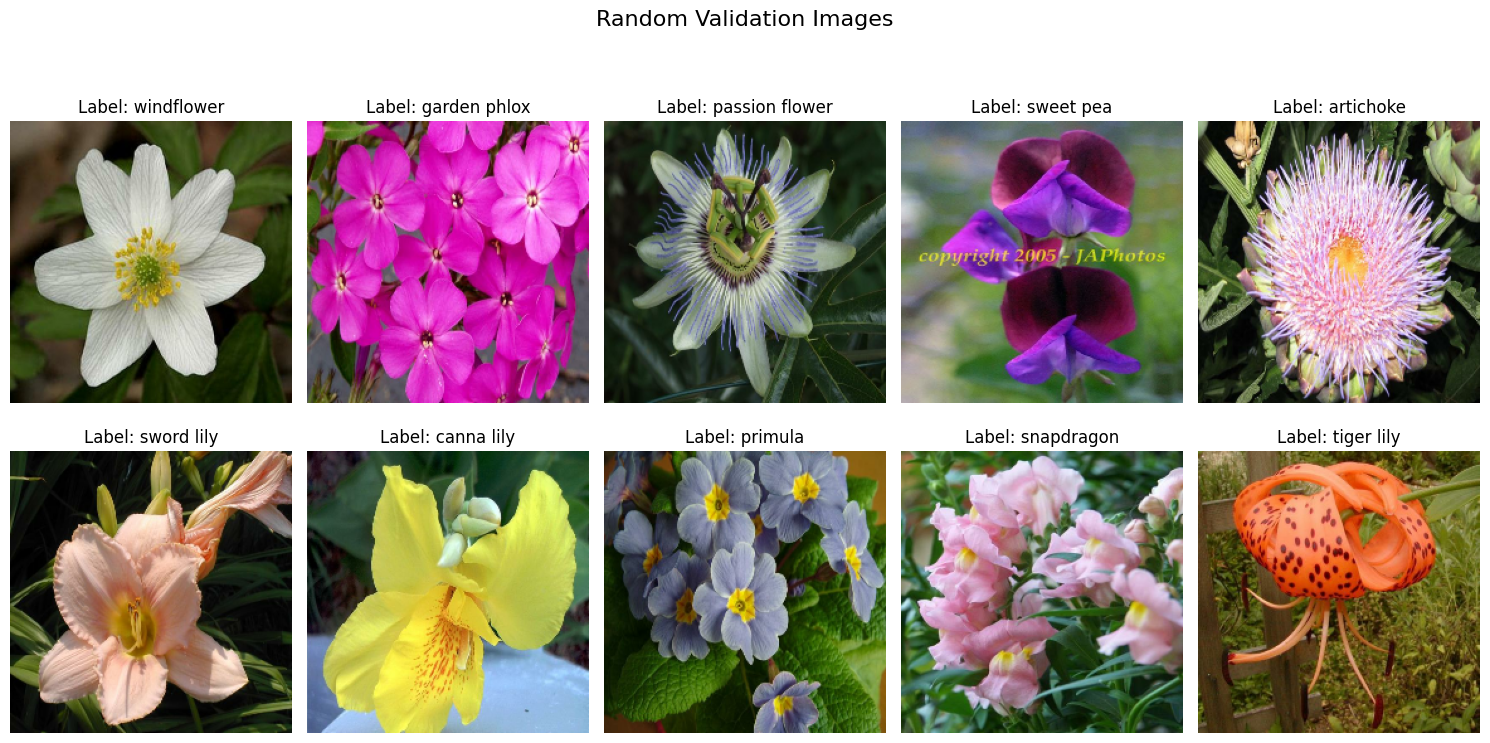

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(dataset, num_images=10, title=""):
    """Displays a grid of images from a tf.data.Dataset.

    Args:
        dataset: A tf.data.Dataset containing (image, label) pairs.
        num_images: The number of images to display.
        title: The title of the plot.
    """
    subset = dataset.take(num_images)

    plt.figure(figsize=(15, 8))  # Adjust figure size as needed
    plt.suptitle(title, fontsize=16)

    for i, (image, label) in enumerate(subset):
        plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots

        display_image = (image.numpy())

        # Ensure the image is within the valid range [0, 1]
        display_image = np.clip(display_image, 0, 1)
        label_num = np.argmax(label.numpy())
        plt.imshow(display_image)
        plt.title(f"Label: {text_labels[label_num]}")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Display Training Images ---
display_images(train_dataset.unbatch(), num_images=10, title="Random Training Images")

# --- Display Validation Images ---
display_images(val_dataset.unbatch(), num_images=10, title="Random Validation Images")

## Feature Extraction

In [ ]:
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Load MobileNetV3 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(102, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))  # 102 flower classes
])

# Compile Model (Feature Extraction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Train for initial feature extraction
initial_epochs = 10
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=initial_epochs
)


Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 50s 69ms/step - accuracy: 0.3753 - loss: 2.8251 - recall: 0.1732 - top_5_accuracy: 0.5996 - val_accuracy: 0.8523 - val_loss: 0.7315 - val_recall: 0.6801 - val_top_5_accuracy: 0.9731
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.7868 - loss: 0.8585 - recall: 0.6353 - top_5_accuracy: 0.9561 - val_accuracy: 0.8864 - val_loss: 0.5354 - val_recall: 0.8107 - val_top_5_accuracy: 0.9829
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.8378 - loss: 0.6566 - recall: 0.7396 - top_5_accuracy: 0.9725 - val_accuracy: 0.8938 - val_loss: 0.4832 - val_recall: 0.8248 - val_top_5_accuracy: 0.9805
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.8593 - loss: 0.5724 - recall: 0.7844 - top_5_accuracy: 0.9795 - val_accuracy: 0.9048 - val_loss: 0.4585 - val_recall: 0.8565 - val_top_5_accuracy: 0.9817
Epoch 5/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.8704 - loss: 0.5342 - recall: 0.8044 - top_5

## Fine-tuning

In [ ]:

# Unfreeze the last ~30 layers of MobileNetV2 for deeper fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

fine_tune_epochs = 50
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.7953 - loss: 1.8768 - recall: 0.6697 - top_5_accuracy: 0.9461 - val_accuracy: 0.8828 - val_loss: 2.1333 - val_recall: 0.8669 - val_top_5_accuracy: 0.9811 - learning_rate: 1.0000e-04
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9440 - loss: 1.3063 - recall: 0.8265 - top_5_accuracy: 0.9957 - val_accuracy: 0.9231 - val_loss: 1.7900 - val_recall: 0.9121 - val_top_5_accuracy: 0.9896 - learning_rate: 1.0000e-04
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9658 - loss: 1.2107 - recall: 0.8734 - top_5_accuracy: 0.9982 - val_accuracy: 0.9359 - val_loss: 1.6203 - val_recall: 0.9182 - val_top_5_accuracy: 0.9908 - learning_rate: 1.0000e-04
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9787 - loss: 1.1560 - recall: 0.9032 - top_5_accuracy: 0.9989 - val_accuracy: 0.9408 - val_loss: 1.4612 - val_recall: 0.9182 - val_top_5_accuracy: 0.9902 - learning_rate: 1.0000e-04


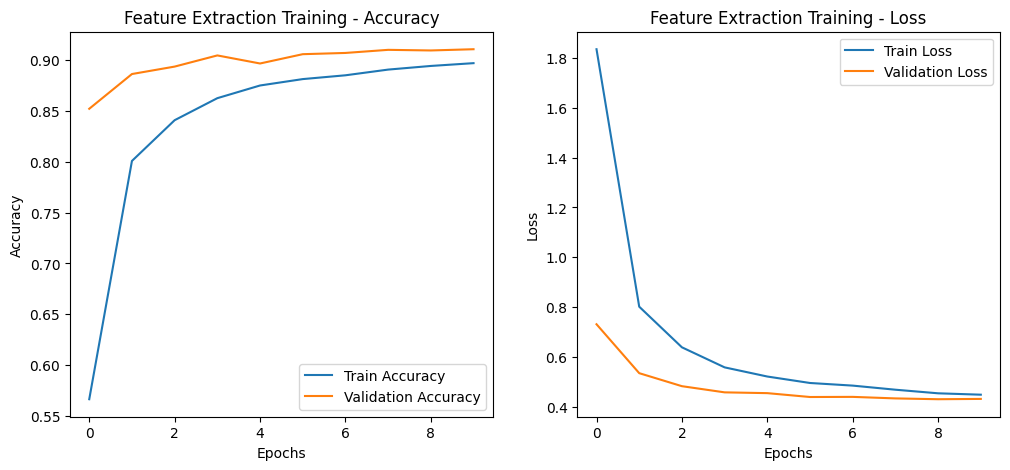

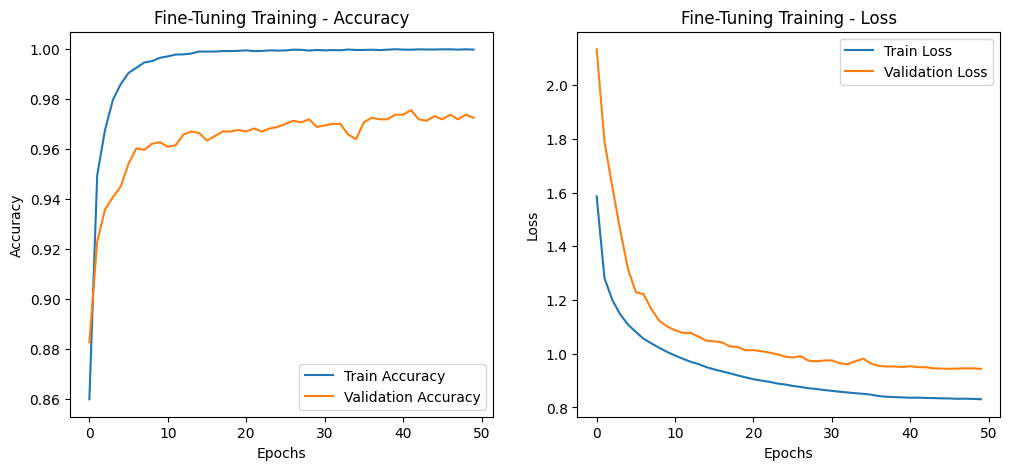

In [ ]:
# Plot Training Metrics
def plot_metrics(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# Display Metrics
plot_metrics(history, title="Feature Extraction Training")
plot_metrics(history_fine, title="Fine-Tuning Training")


In [ ]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Display a larger confusion matrix heatmap.
    Annotate only those cells where cm[i, j] > 0.
    """
    num_classes = cm.shape[0]

    plt.figure(figsize=(20, 12))  # Increase figure size as desired
    plt.imshow(cm, interpolation='nearest', cmap='Greys')
    plt.title(title)
    plt.colorbar()

    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")

    # Annotate the cells only if there's a non-zero count
    for i in range(num_classes):
        for j in range(num_classes):
            if cm[i, j] > 0:
                plt.text(
                    j, i,                # (x, y) positions
                    str(cm[i, j]),       # the text (cell value)
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="red",         # choose color that stands out
                    fontsize=9
                )

    plt.tight_layout()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


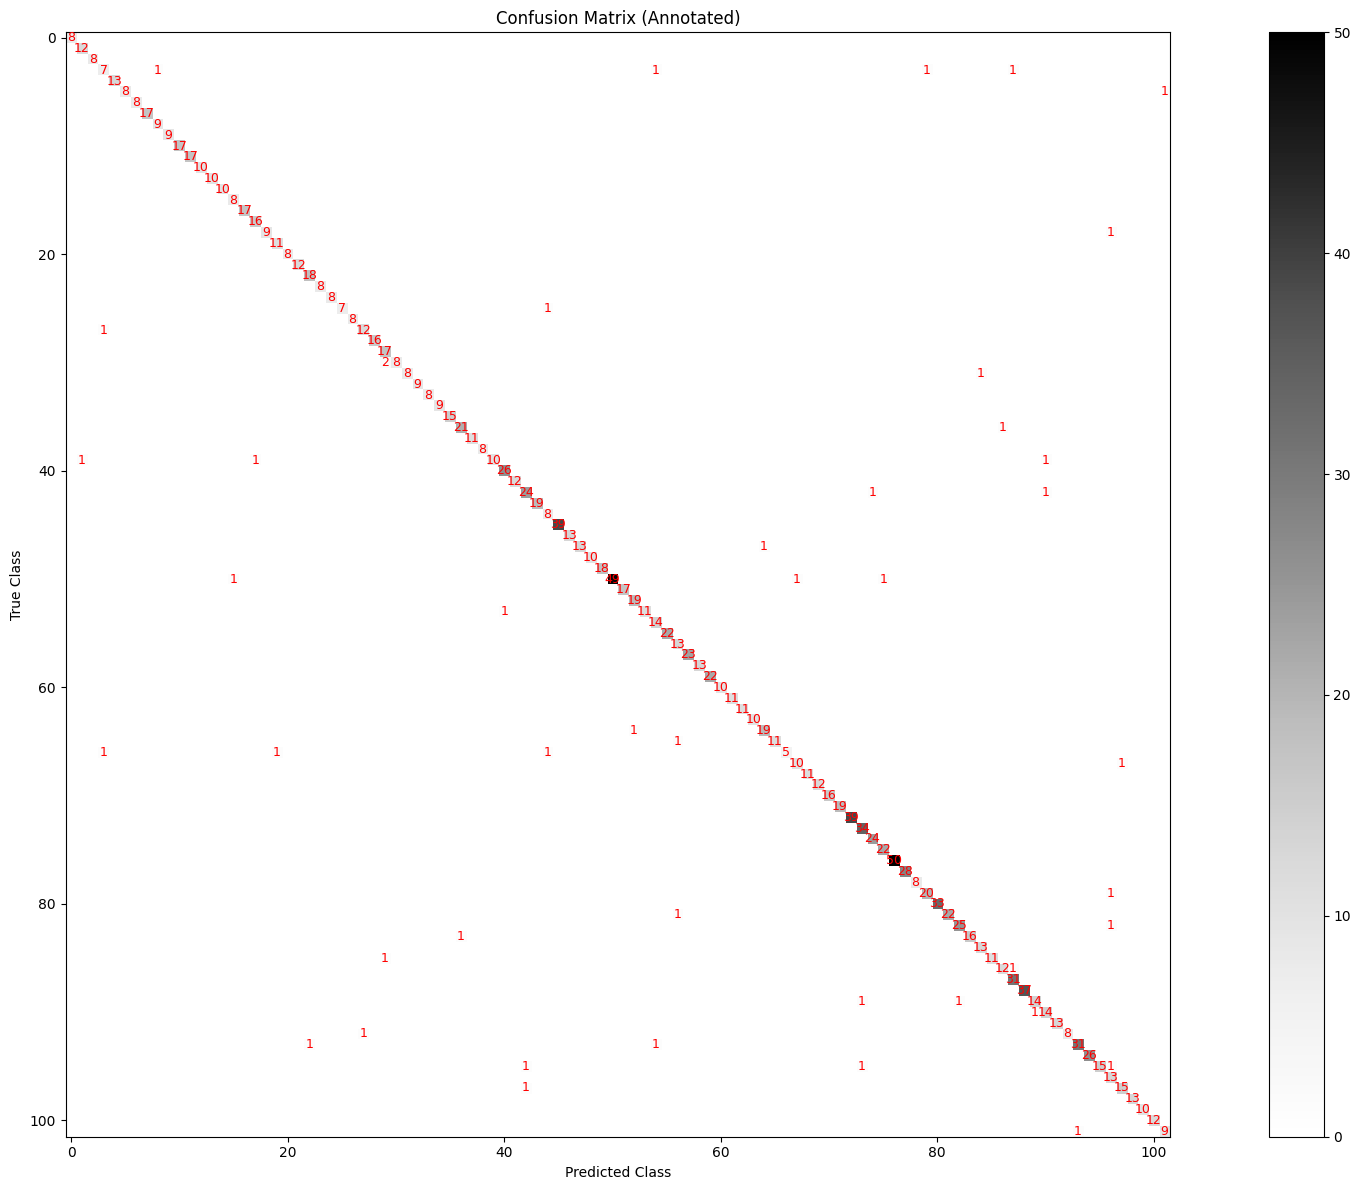

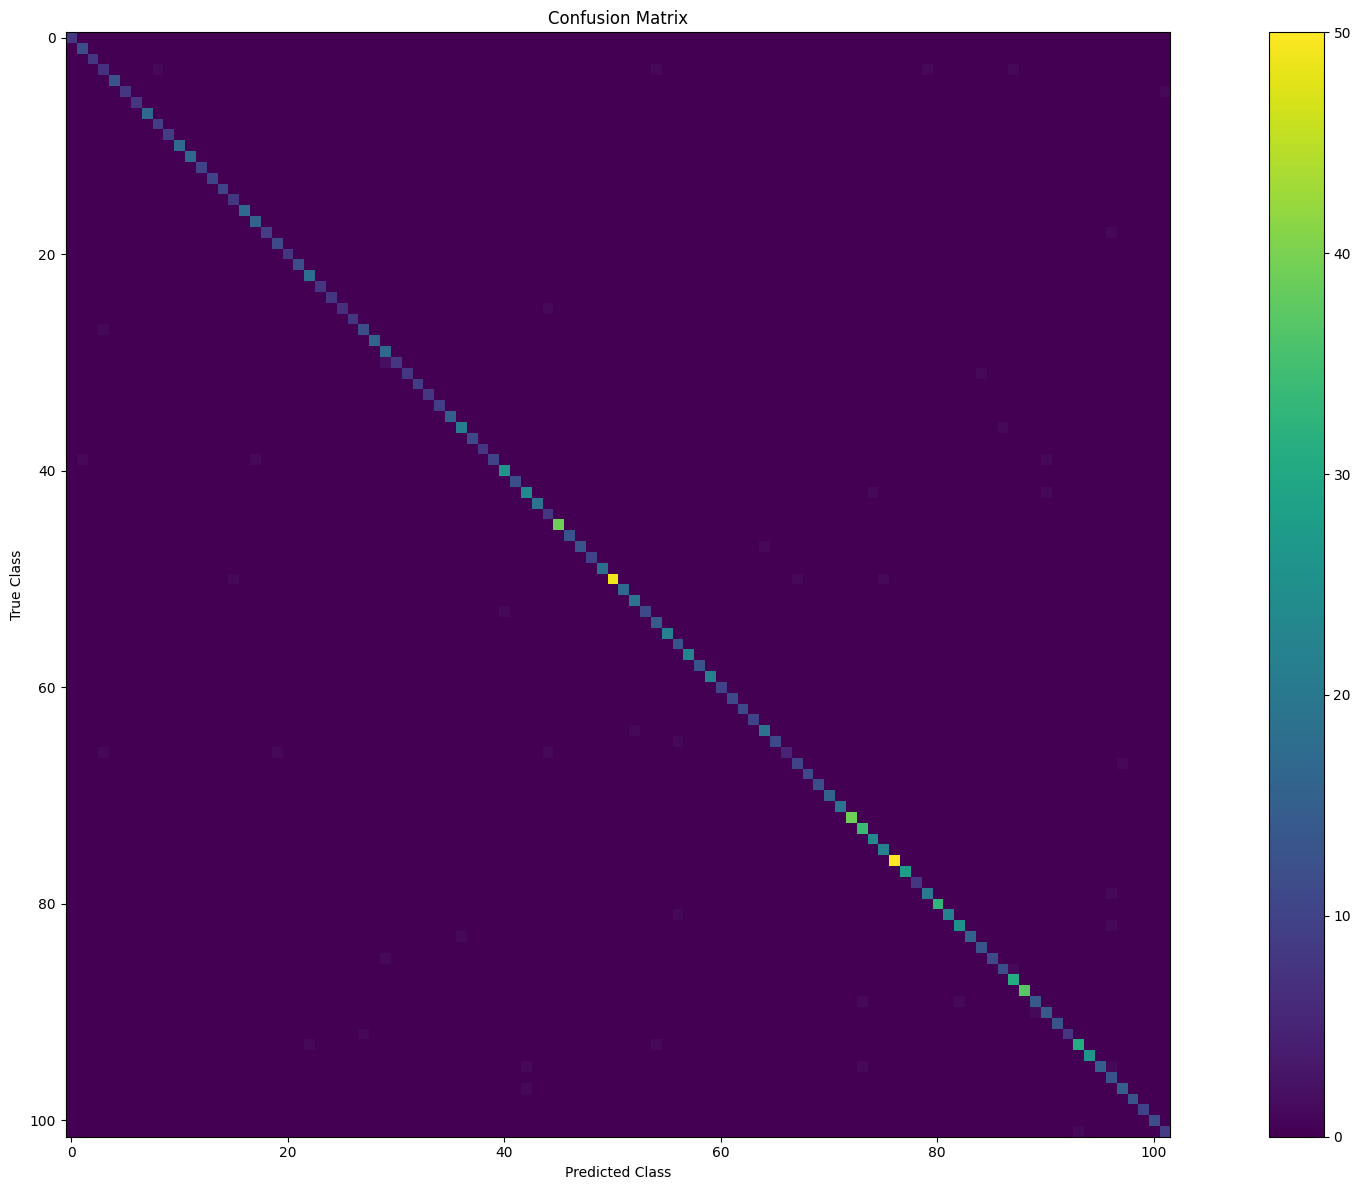

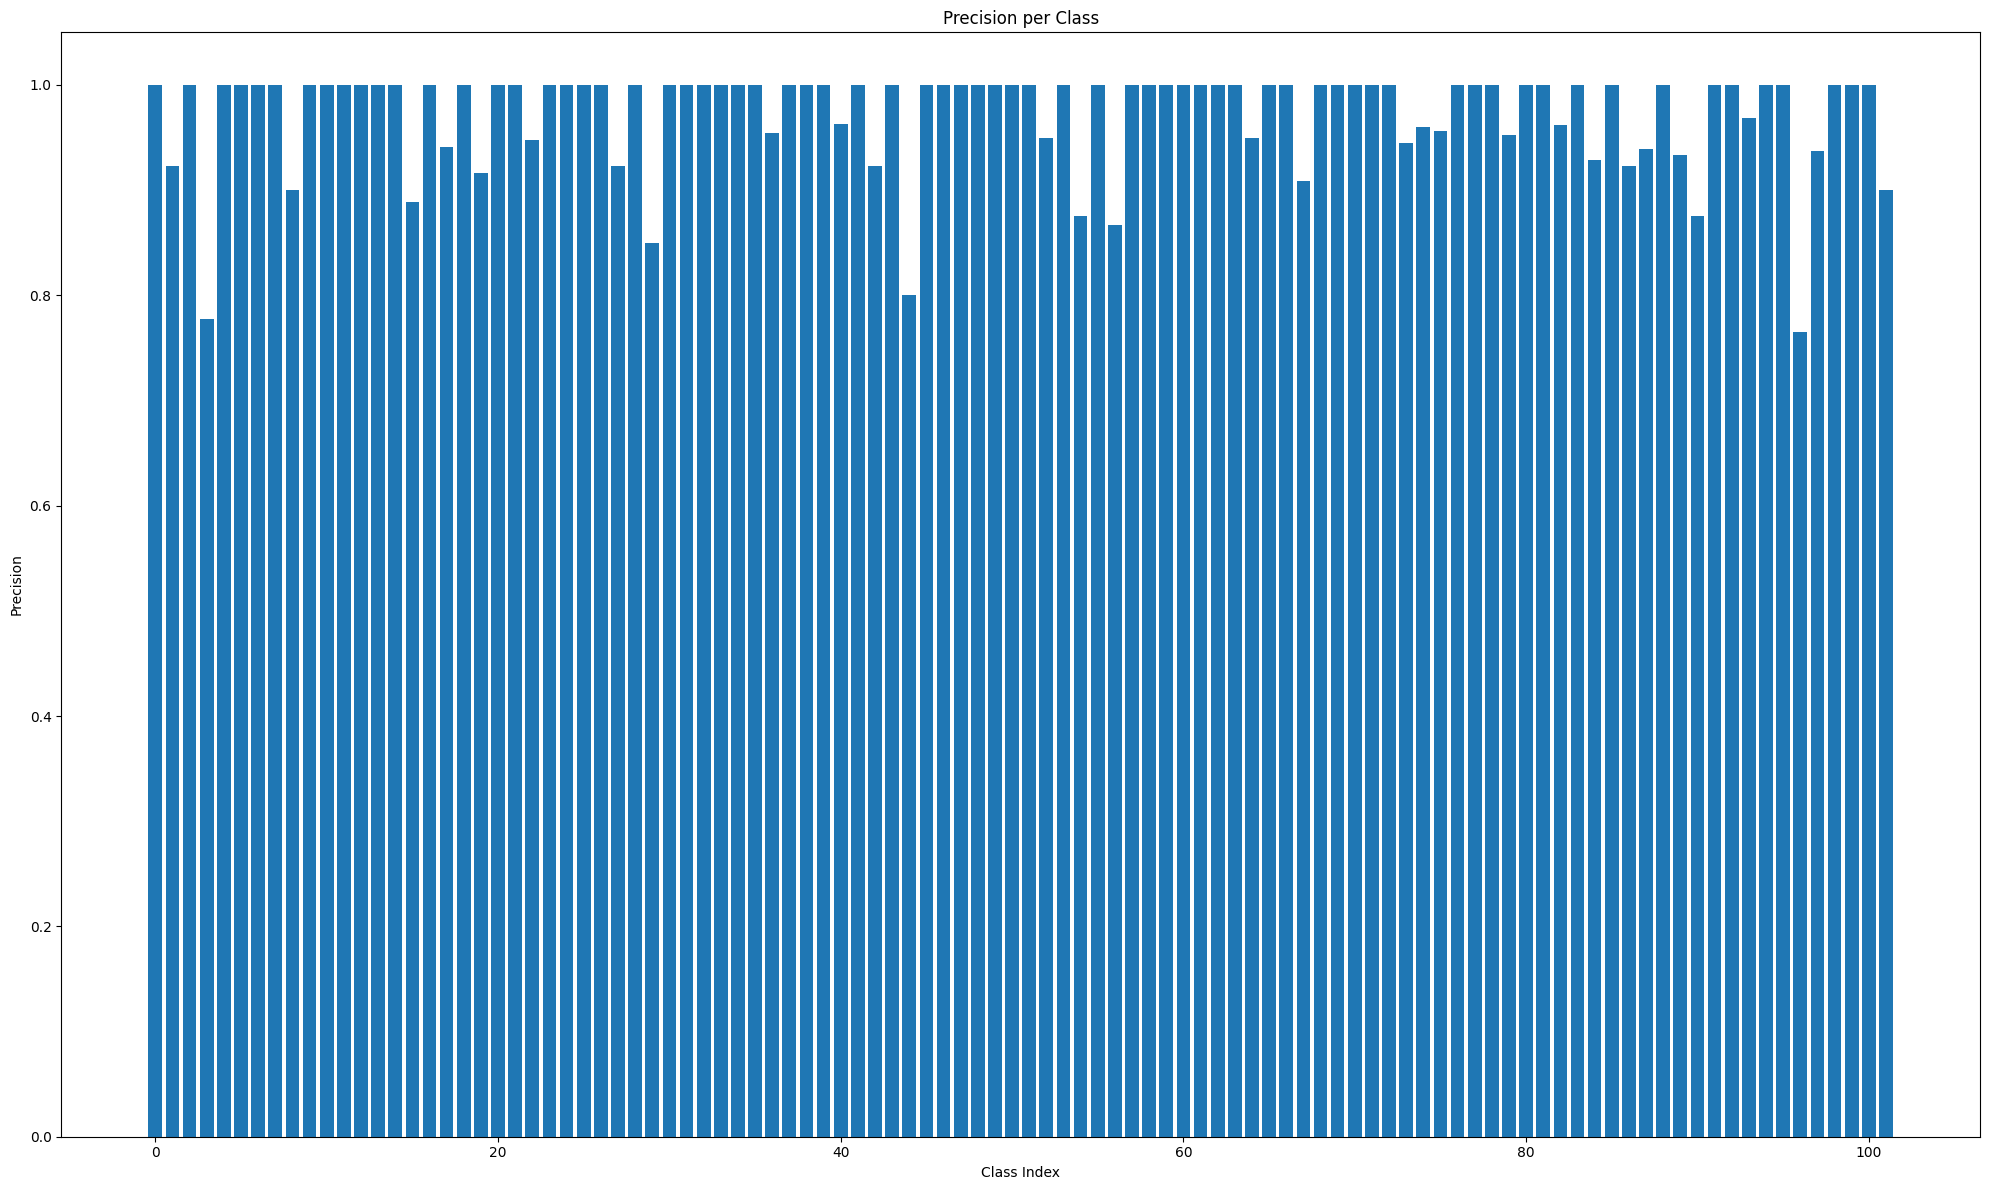

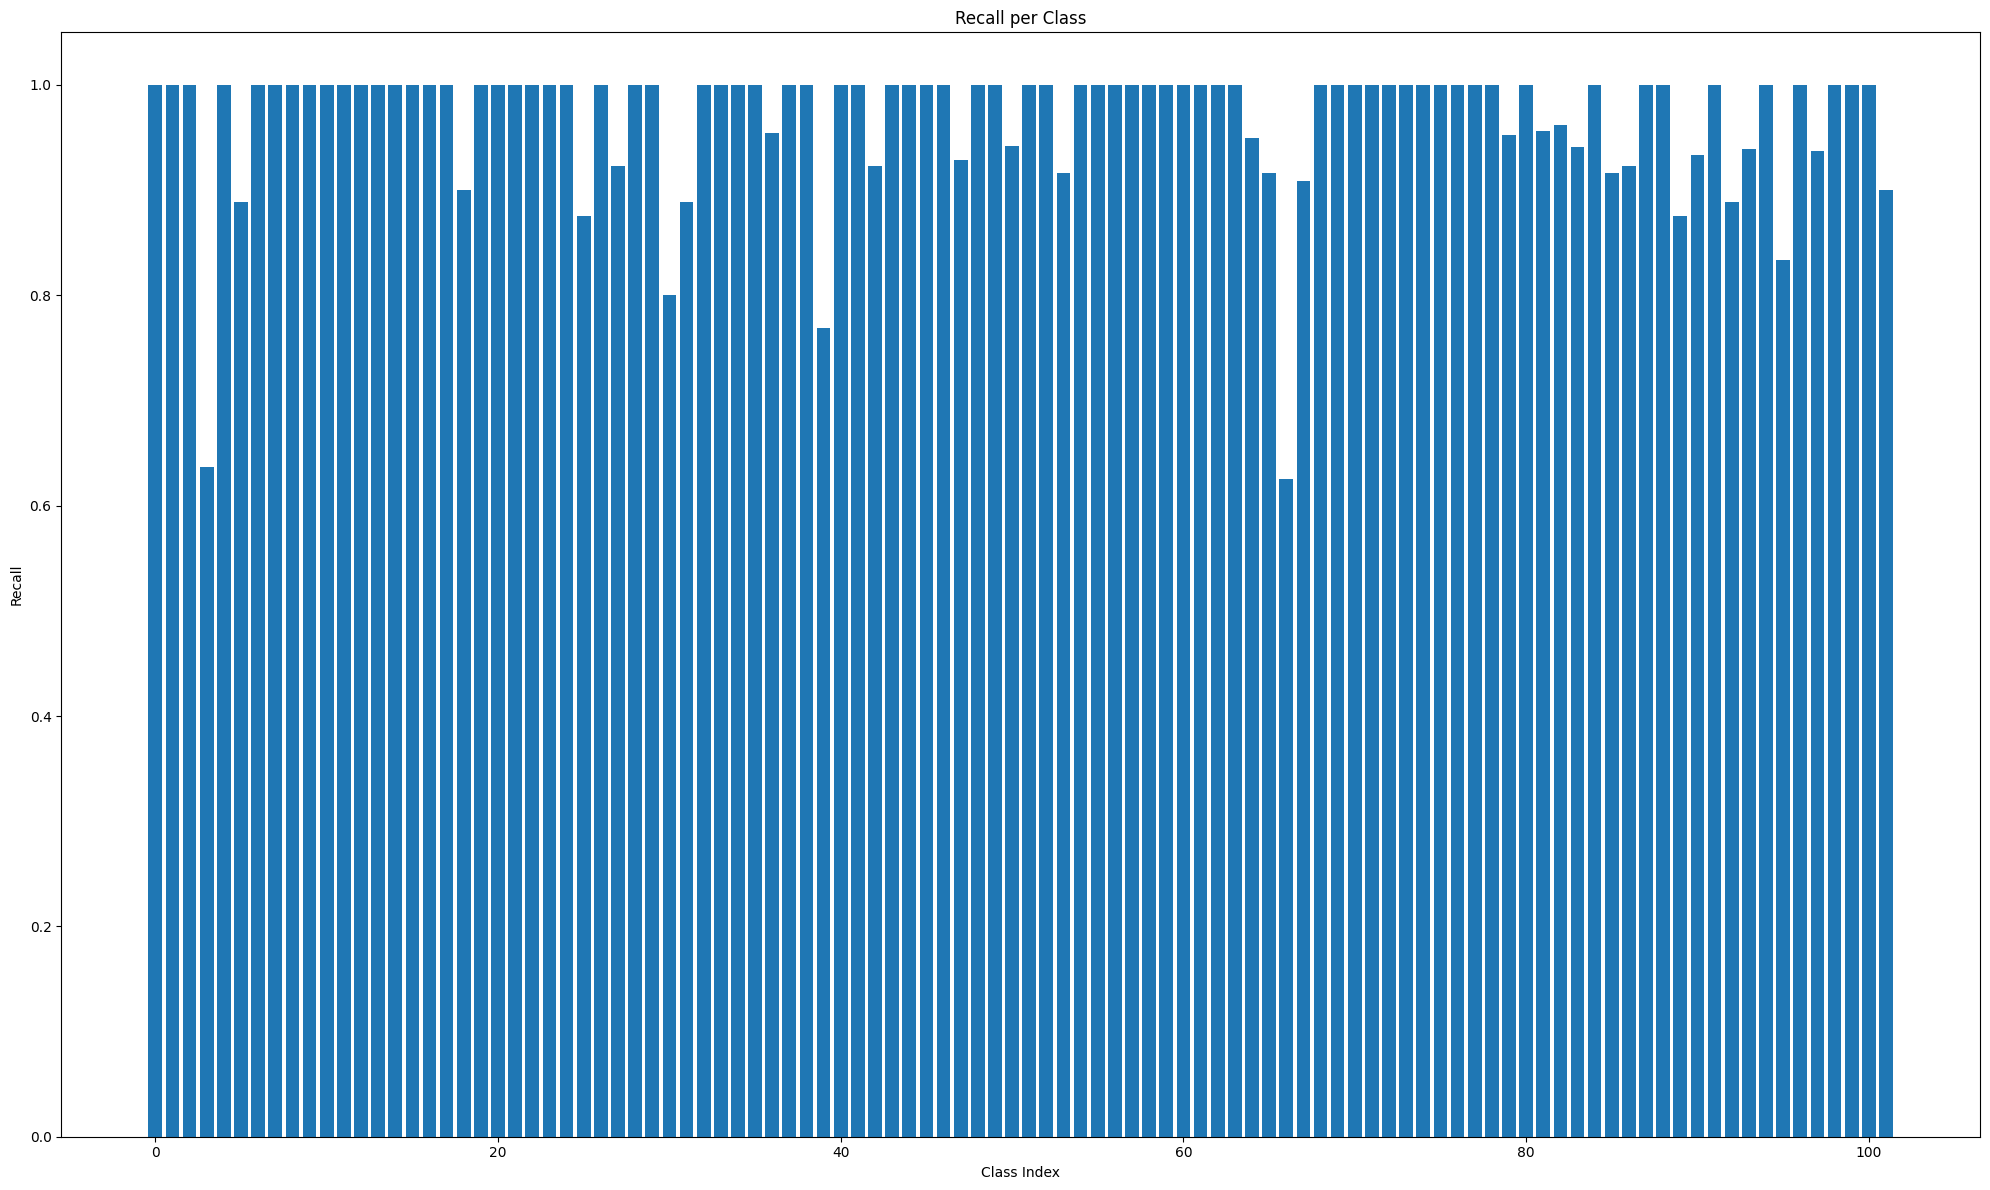

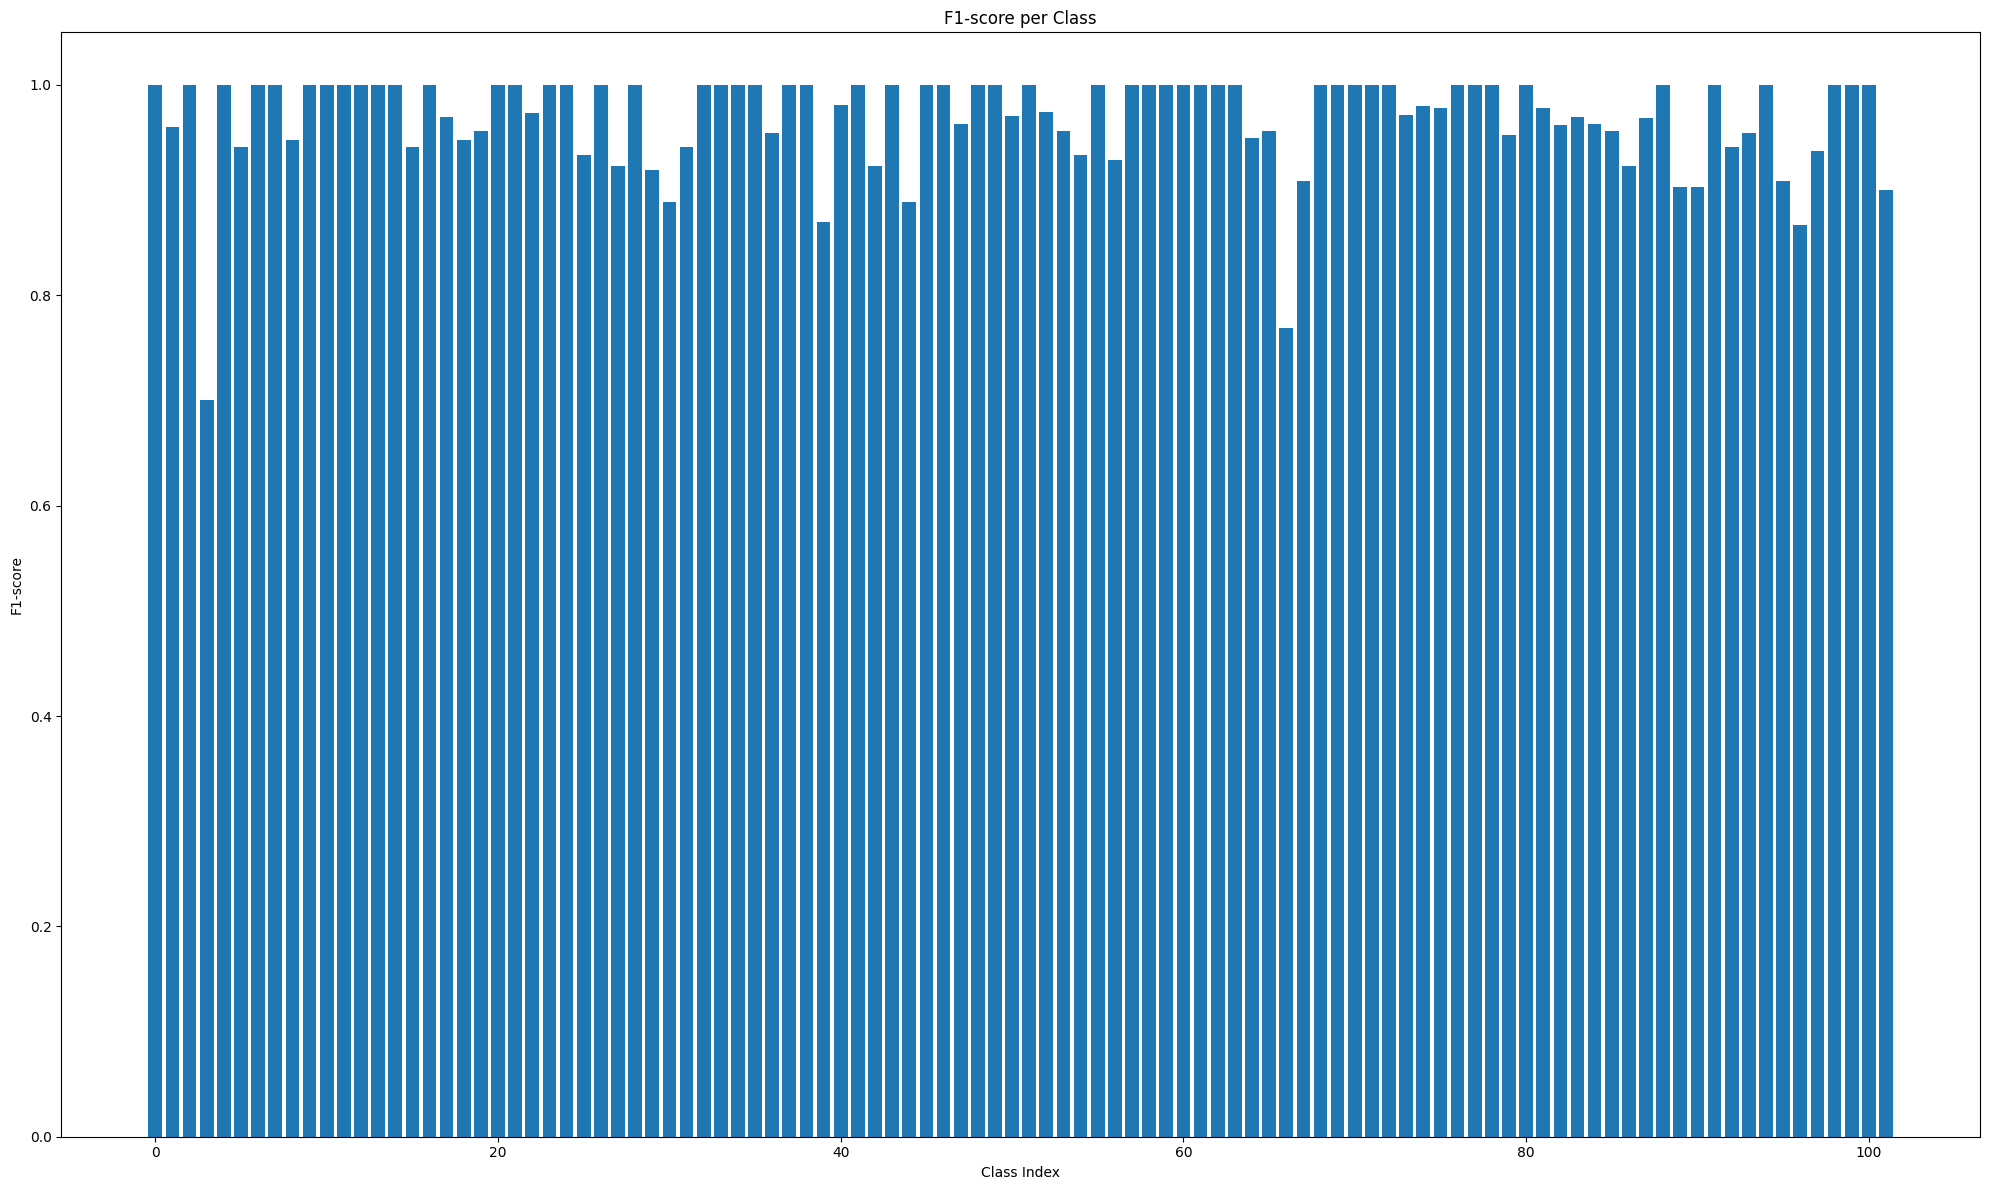

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# =========== Gather Predictions for Validation ===========
y_true = []
y_pred = []
for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))    # true class index
    y_pred.extend(np.argmax(preds, axis=1))     # predicted class index

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# =========== Confusion Matrix & Classification Report ===========
cm = confusion_matrix(y_true, y_pred)
report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

plot_confusion_matrix(cm, title="Confusion Matrix (Annotated)")

plt.figure(figsize=(20, 12))
plt.imshow(cm, interpolation='nearest')  # default colormap
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()

# =========== Plot Per-Class Precision, Recall, and F1 ===========

class_indices = []
precision_vals = []
recall_vals = []
f1_vals = []

for key in report_dict.keys():
    # Exclude 'accuracy', 'macro avg', 'weighted avg'
    if key.isdigit():
        class_indices.append(int(key))
        precision_vals.append(report_dict[key]['precision'])
        recall_vals.append(report_dict[key]['recall'])
        f1_vals.append(report_dict[key]['f1-score'])

# Sort these by class index just in case
sorted_idx = np.argsort(class_indices)
class_indices = np.array(class_indices)[sorted_idx]
precision_vals = np.array(precision_vals)[sorted_idx]
recall_vals = np.array(recall_vals)[sorted_idx]
f1_vals = np.array(f1_vals)[sorted_idx]

# --- Precision Bar Chart ---
plt.figure(figsize=(20, 12))
plt.bar(class_indices, precision_vals)
plt.title("Precision per Class")
plt.xlabel("Class Index")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

# --- Recall Bar Chart ---
plt.figure(figsize=(20, 12))
plt.bar(class_indices, recall_vals)
plt.title("Recall per Class")
plt.xlabel("Class Index")
plt.ylabel("Recall")
plt.tight_layout()
plt.show()

# --- F1 Bar Chart ---
plt.figure(figsize=(20, 12))
plt.bar(class_indices, f1_vals)
plt.title("F1-score per Class")
plt.xlabel("Class Index")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

In [ ]:
import shutil
import os

def delete_folders(folders_to_delete):
  """Deletes a list of folders and their contents.

  Args:
    folders_to_delete: A list of folder paths to delete.
  """
  for folder in folders_to_delete:
    if os.path.exists(folder):
      try:
          shutil.rmtree(folder)
          print(f"Successfully deleted folder: {folder}")
      except OSError as e:
          print(f"Error deleting folder {folder}: {e}")
    else:
      print(f"Folder not found: {folder}")


folders_to_delete = ["model"]
delete_folders(folders_to_delete)


In [ ]:


tf.saved_model.save(model, "model/tf/mobileV2/")



In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve --weight_shard_size_bytes=30000000 model/tf/mobileV2/ model/tf2js/mobileV2

2025-03-23 22:15:02.954232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742768102.976641  133636 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742768102.983426  133636 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742768103.000896  133636 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742768103.000923  133636 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742768103.000926  133636 computation_placer.cc:177] computation placer alr